# Calibration

It is best to think of an event being calibrated in ATLAS, rather than single objects. In most cases it does not make sense to have one type of object calibrated while another isn't. Or even to have them individually calibrated. This is because there are interdependencies between some objects. For example, the calibrated jets, electrons, photons, muons, and taus are all used to calculate the missing ET for an event. Further, after calibrating jets, electrons, photons, muons, and taus one must run overlap removal to disambiguate, say, jets and electrons.

As a result, it only makes sense to talk about a coherent, calibrated set of objects in an ATLAS event. Further, due to limitations in how `AnalysisBase` (which extracts the data from xAOD's) and `func_adl`'s calibration model implemented here, it is not possible to run with more than a single calibration configuration in a single query. You'll have to split them up into multiple queries.

`func_adl` has calibration configuration class. Its contains a basic view of the event - what jet collection to use, what muon working point to use, etc. This is configured by default to work well for `DAOD_PHYS` and `DAOD_PHYSLITE`. In the end, these have to configure the common CP algorithms for calibration and systematic errors. If you do nothing, this is the configuration you'll get. However, if you need a different calibration configuration it is possible to modify, as we will see below.

In [1]:
from config import ds_zee as ds
from config import match_eta_phi
from func_adl_servicex_xaodr21 import calib_tools
import matplotlib.pyplot as plt
import awkward as ak

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


## The Calibration Configuration Object

The default calibration object details all the various objects that are used. You can grab the default and inspect it yourself:

In [2]:
print(calib_tools.default_config)

CalibrationEventConfig(jet_collection='AntiKt4EMPFlowJets', jet_calib_truth_collection='AntiKt4TruthDressedWZJets', electron_collection='Electrons', electron_working_point='MediumLHElectron', electron_isolation='NonIso', photon_collection='Photons', photon_working_point='Tight', photon_isolation='FixedCutTight', muon_collection='Muons', muon_working_point='Medium', muon_isolation='NonIso', tau_collection='TauJets', tau_working_point='Tight')


When you request `Jet`'s, for example, you'll be getting back fully calibrated and overlap pruned jets. The jets will have started from the `default_calibration.jet_collection` entry above (this is the same as we saw on the Jets chapter):

In [3]:
pflow_jets = (ds
        .Select(lambda e: e.Jets())
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta() / 1000.0),
                'phi': jets.Select(lambda j: j.phi() / 1000.0),
        })
        .AsAwkwardArray()
        .value())

You can reset the default collection if you desire.  All queries that occur after the default calibration configuration is configured will use this new default. Note that calibration configuration is captured at run time (when you use `value` or its equivalent), not when you use the `Jets` method, etc.

This example modifies the default calibration configuration to use a new jet collection. The identical query above will return a different set of (calibrated) jets:

In [4]:
new_jet_selection = calib_tools.default_config
new_jet_selection.jet_collection = 'AntiKt4EMTopoJets'
calib_tools.set_default_config(new_jet_selection)

antikt_jets = (ds
        .Select(lambda e: e.Jets())
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta() / 1000.0),
                'phi': jets.Select(lambda j: j.phi() / 1000.0),
        })
        .AsAwkwardArray()
        .value())

And we can see that the PFlow algorithm returns more jets than the anti-kt4 algorithm. And that they are mostly at lower jet $p_T$'s:

In [9]:
len(ak.flatten(pflow_jets.pt)), len(ak.flatten(antikt_jets.pt))

(25560, 23567)

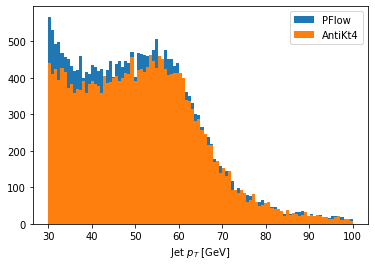

In [10]:
plt.hist(ak.flatten(pflow_jets.pt), label='PFlow', bins=100, range=(30, 100))
plt.hist(ak.flatten(antikt_jets.pt), label='AntiKt4', bins=100, range=(30, 100))
plt.legend()
_ = plt.xlabel('Jet $p_T$ [GeV]')

In [11]:
pflow_matched_jets_to_antikt = match_eta_phi(antikt_jets, pflow_jets)

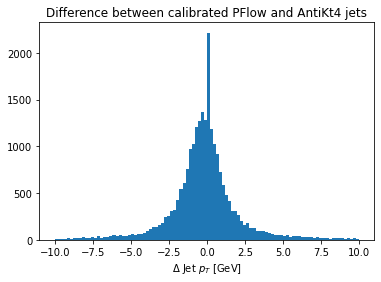

In [13]:
plt.hist(ak.flatten(pflow_matched_jets_to_antikt.pt - antikt_jets.pt), bins=100, range=(-10, 10))
plt.title('Difference between calibrated PFlow and AntiKt4 jets')
_ = plt.xlabel('$\\Delta$ Jet $p_T$ [GeV]')

And then we can use `calib_tools.reset_config()` to reset to factory default. Though this is mostly for test harneses and the like. Remember, the `default_collection` is a global variable, so it is fairly dangerous to modify unless you really want to change it for everything.

Note: This is particularly dangerous in a notebook where one can execute cells out of order. If you execute the cell above to get `pflow_jets` after the `antikt_jets` cell, you'll get AntiKt4EMToploJets in your pflow jets! Best practice: Use this technique if you are setting the calibration once for your analysis in central a configuration file.

In [14]:
calib_tools.reset_config()

## Modifying the calibrated collection in the query

You can modify an aspect of the calibration on a query-by-query basis without using global variables. There are two ways to do this.

First, you can specify the collection to load in place of the default in the `Jets` (or similar) method. This will alter the collection name and run the full calibration. This is useful for quick tests: it is convinent, and keeps the new bank name close to where you make the request - so it is readable.

In [15]:
jetname_in_query_jets = (ds
        .Select(lambda e: e.Jets(calibrated_collection="AntiKt4EMTopoJets"))
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta() / 1000.0),
                'phi': jets.Select(lambda j: j.phi() / 1000.0),
        })
        .AsAwkwardArray()
        .value())

And we can see there are no differences in the data we've pulled here:

In [16]:
ak.sum(abs(jetname_in_query_jets.pt - antikt_jets.pt))

0.0

However, this doesn't work well if you want to alter more than calibration configuration value. There is a helper function, `calib_tools.query_update` that allows you to modify single in the calibration configuration. You can also chain the calls, and the modifications will accumulate.

In [17]:
config_jets_in_query_jets = (calib_tools.query_update(ds, jet_collection='AntiKt4EMTopoJets')
        .Select(lambda e: e.Jets())
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta() / 1000.0),
                'phi': jets.Select(lambda j: j.phi() / 1000.0),
        })
        .AsAwkwardArray()
        .value())

In [18]:
ak.sum(abs(config_jets_in_query_jets.pt - antikt_jets.pt))

0.0

You can even set a whole new configuration if you have lots of changes at once. This will override anything you've previously set with `query_update` in the query.

In [19]:
config_in_query_jets = (calib_tools.query_update(ds, new_jet_selection)
        .Select(lambda e: e.Jets())
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta() / 1000.0),
                'phi': jets.Select(lambda j: j.phi() / 1000.0),
        })
        .AsAwkwardArray()
        .value())

In [20]:
ak.sum(abs(config_in_query_jets.pt - antikt_jets.pt))

0.0

## Systematic Errors

You can only query a single systematic error at a time in this version. You do this by specifying the systematic error you want using the helper method `calib_tools.query_sys_error`. By default, the central value is returned (`NOSYS`). You will need to know the names of the systematic errors a head of time in order to use this. This method will modify the systematic error for the rest of this query.

In [21]:
sys_jets = (calib_tools.query_sys_error(ds, 'JET_Pileup_PtTerm__1up')
            .Select(lambda e: e.Jets())
            .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
            .Select(lambda jets: {
                    'pt': jets.Select(lambda j: j.pt() / 1000.0),
                    'eta': jets.Select(lambda j: j.eta() / 1000.0),
                    'phi': jets.Select(lambda j: j.phi() / 1000.0),
            })
            .AsAwkwardArray()
            .value())

And we can compare the values to see how big a correction this is by doing the $\eta-\phi$ matching:

In [25]:
sys_jet_matched = match_eta_phi(pflow_jets, sys_jets)

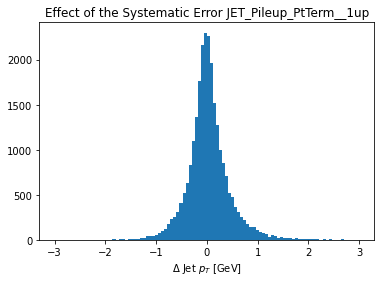

In [27]:
plt.hist(ak.flatten(pflow_jets.pt - sys_jet_matched.pt), bins=100, range=(-3, 3))
plt.title('Effect of the Systematic Error JET_Pileup_PtTerm__1up')
_ = plt.xlabel('$\\Delta$ Jet $p_T$ [GeV]')

By comparing eta/phi we can see how big an effect our jet calibrations and systematic error have made here:

While this works, it clearly can't be the final way to do this. Espeically given the push model that ATLAS uses for systematic errors. Thoughts welcome at this issue on how to implement systematic errors in the ATLAS xAOD system for `func_adl`.

## Uncalibrated Collections

For some Collections, but not all...You can also request an explicit bank. For example, we can compare the overlap and calibrated jets above with the jets in the actual starting bank:

In [22]:
default_jets = calib_tools.default_config.jet_collection
print(f"Default jet collection: {default_jets}")
uncalibrated_jets = (ds
        .Select(lambda e: e.Jets(uncalibrated_collection=default_jets))
        .Select(lambda jets: jets.Where(lambda j: (j.pt() / 1000) > 30))
        .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta() / 1000.0),
                'phi': jets.Select(lambda j: j.phi() / 1000.0),
        })
        .AsAwkwardArray()
        .value())

Default jet collection: AntiKt4EMPFlowJets


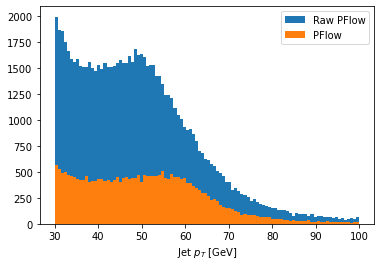

In [24]:
plt.hist(ak.flatten(uncalibrated_jets.pt), label='Raw PFlow', bins=100, range=(30, 100))
plt.hist(ak.flatten(pflow_jets.pt), label='PFlow', bins=100, range=(30, 100))
plt.legend()
_ = plt.xlabel('Jet $p_T$ [GeV]')

In [28]:
uncalibrated_matched = match_eta_phi(pflow_jets, uncalibrated_jets)

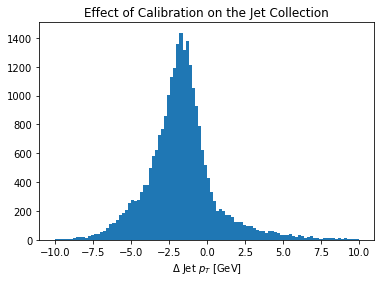

In [30]:
plt.hist(ak.flatten(pflow_jets.pt - uncalibrated_matched.pt), bins=100, range=(-10, 10))
plt.title('Effect of Calibration on the Jet Collection')
_ = plt.xlabel('$\\Delta$ Jet $p_T$ [GeV]')

## AnalysisBase Configuration Code

In the end, the analysis base python configuration code must be run. This code is stored as `jinja2` templates, in files, in the package. Currently you have to modify those, however, if there is a request it isn't very difficult to make it possible to modify them in your code and configuration.